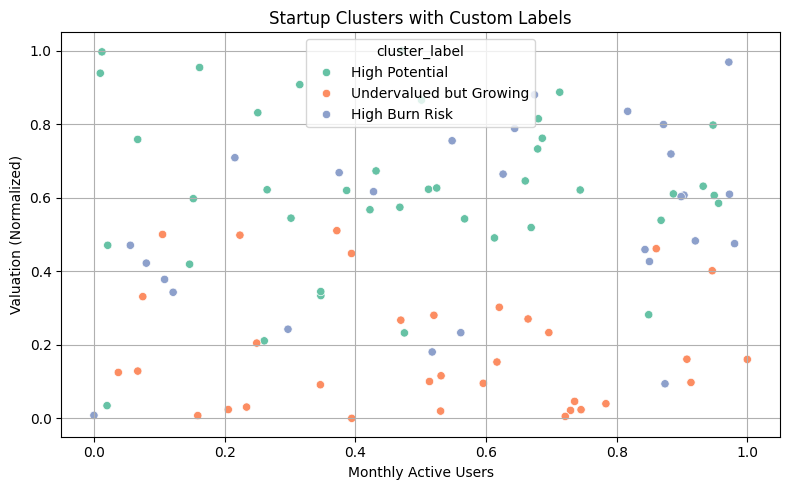

🔍 Random Forest RMSE: 6.089518442347883
🔍 Random Forest R²: 0.8277201908462349
🔍 XGBoost RMSE: 6.2319995819867975
🔍 XGBoost R²: 0.8195639493038717


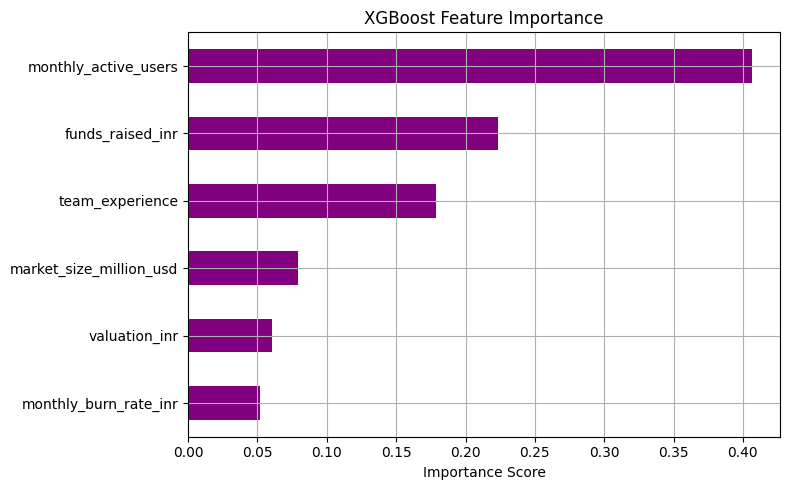

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("Startup_Scoring_Dataset.csv")


normalized_df = df.copy()
positive_features = ['team_experience', 'market_size_million_usd', 'monthly_active_users', 'funds_raised_inr', 'valuation_inr']
negative_features = ['monthly_burn_rate_inr']


for col in positive_features:
    normalized_df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


for col in negative_features:
    normalized_df[col] = 1 - ((df[col] - df[col].min()) / (df[col].max() - df[col].min()))


weights = {
    'team_experience': 0.15,
    'market_size_million_usd': 0.20,
    'monthly_active_users': 0.25,
    'monthly_burn_rate_inr': 0.10,
    'funds_raised_inr': 0.15,
    'valuation_inr': 0.15
}

normalized_df['final_score'] = sum(normalized_df[feature] * weight * 100 for feature, weight in weights.items())
normalized_df['rank'] = normalized_df['final_score'].rank(ascending=False, method='min').astype(int)



X = normalized_df[positive_features + negative_features]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
normalized_df['cluster'] = kmeans.fit_predict(X_scaled)


def label_cluster(row):
    if row['cluster'] == 0:
        return "High Potential"
    elif row['cluster'] == 1:
        return "High Burn Risk"
    else:
        return "Undervalued but Growing"

normalized_df['cluster_label'] = normalized_df.apply(label_cluster, axis=1)


plt.figure(figsize=(8, 5))
sns.scatterplot(x='monthly_active_users', y='valuation_inr', hue='cluster_label', data=normalized_df, palette='Set2')
plt.title("Startup Clusters with Custom Labels")
plt.xlabel("Monthly Active Users")
plt.ylabel("Valuation (Normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()


X_features = normalized_df[positive_features + negative_features]
y_score = normalized_df['final_score']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_score, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("🔍 Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("🔍 Random Forest R²:", r2_score(y_test, rf_pred))


xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("🔍 XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("🔍 XGBoost R²:", r2_score(y_test, xgb_pred))


importance = pd.Series(xgb_model.feature_importances_, index=X_features.columns).sort_values(ascending=True)
plt.figure(figsize=(8, 5))
importance.plot(kind='barh', color='purple')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


normalized_df.to_csv("scored_startups_with_clusters.csv", index=False)


In [3]:

cluster_summary = normalized_df.groupby('cluster_label')[[
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'monthly_burn_rate_inr',
    'funds_raised_inr',
    'valuation_inr',
    'final_score'
]].mean().round(2)

print("📊 Cluster Interpretation Summary:")
print(cluster_summary)


📊 Cluster Interpretation Summary:
                         team_experience  market_size_million_usd  \
cluster_label                                                       
High Burn Risk                      0.86                     0.53   
High Potential                      0.48                     0.49   
Undervalued but Growing             0.36                     0.63   

                         monthly_active_users  monthly_burn_rate_inr  \
cluster_label                                                          
High Burn Risk                           0.59                   0.53   
High Potential                           0.48                   0.33   
Undervalued but Growing                  0.51                   0.61   

                         funds_raised_inr  valuation_inr  final_score  
cluster_label                                                          
High Burn Risk                       0.74           0.53        62.86  
High Potential                       0.24  

   startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0        S001         0.666667                 0.789206              0.669162   
1        S002         0.333333                 0.941955              0.347274   
2        S003         0.777778                 0.028513              0.744235   
3        S004         0.444444                 0.043788              0.949320   
4        S005         0.666667                 0.507128              0.616813   
..        ...              ...                      ...                   ...   
95       S096         1.000000                 0.318737              0.517685   
96       S097         0.888889                 0.684318              0.674190   
97       S098         0.666667                 0.224033              0.037326   
98       S099         0.888889                 0.828921              0.055718   
99       S100         0.777778                 0.233198              0.595851   

    monthly_burn_rate_inr  